In [115]:
using VeryDiff
using LinearAlgebra
using Plots
using DataStructures
using Gurobi, JuMP

function to_dict_key(node :: SplitNode)
    (;network, layer, neuron) = node
    return "$network,$layer,$neuron"
end

function split_neuron(node :: SplitNode, prev_split :: Tuple{DiffZonotope, Vector{SplitNode}})
    split₁ = prev_split
    split₂ = deepcopy(prev_split)

    push!(split₁[2], SplitNode(node.network, node.layer, node.neuron, -1))
    push!(split₂[2], SplitNode(node.network, node.layer, node.neuron, 1))

    return split₁, split₂
end

include("util.jl")

VeryDiff.NEW_HEURISTIC = false

false

In [116]:
layers1 = Layer[
    Dense([1.7901994999337738 -0.4375139492492878; -0.6463011149536566 -0.294362301893835], [0.4858268442695409, -0.3083995832971191]),
    ReLU(),
    Dense([1.347707452913051 -0.3146188184438083; -0.1724980704319044 1.3150142870758215], [-1.6489691121810657, 0.3154201062043038]),
    ReLU(),
    Dense([0.031313002692325044 0.9255109945797536; -0.6436521744948884 1.2500342629765357], [0.8820501333110521, -0.4141060871972209]),
    ReLU(),
    Dense([0.9686008564499987 -1.802808013449341; -0.18884926111600128 0.7735822224964346], [0.4599300554775193, -0.27958078103580214]),
    ReLU(),
    Dense([-0.37566416722901746 0.5662474712485283; -1.152400376401409 -0.12230326369286959], [0.05556857907521722, 0.0887560097096626]),
    ReLU(),
    Dense([0.4877370152355362 0.3992903477728307; -0.4916371434675079 -1.1227964794060794], [0.29456667601848685, 1.083292811708767]),
    ReLU(),
    Dense([0.08926318457803685 0.765030610066109; 0.9024287529989173 -0.7545201379880397], [-0.015334676676834219, 0.5675979257285917]),
    ReLU(),
    Dense([0.7673904813047289 -1.542237049832504; 0.010884097127559778 0.9322644923018855], [-1.3651666407584295, 0.023879238059846247]),
    ReLU(),
    Dense([0.3180228415729041 -0.07903625695921851; 0.9425850271902696 -0.7464757431612407], [-0.624130698523964, -0.2697997653000221]),
    ReLU(),
    Dense([0.17872459879005195 -0.179797304032193; -2.1836695250289 1.3454711687175822], [-0.12013260230442856, -1.0314024426119974]),
    ReLU(),
    Dense([-2.045191560947058 0.45139193468340244; -0.38928407556392314 -0.39667410409807896], [-0.6058976531933701, -0.7965043036498215]),
    ReLU()
]

layers2 = Layer[
    Dense([1.8001994999337738 -0.4375139492492878; -0.6463011149536566 -0.284362301893835], [0.49582684426954093, -0.2983995832971191]),
    ReLU(),
    Dense([1.357707452913051 -0.3146188184438083; -0.1724980704319044 1.3250142870758215], [-1.6389691121810657, 0.3254201062043038]),
    ReLU(),
    Dense([0.041313002692325046 0.9255109945797536; -0.6436521744948884 1.2600342629765358], [0.8920501333110521, -0.4041060871972209]),
    ReLU(),
    Dense([0.9786008564499987 -1.802808013449341; -0.18884926111600128 0.7835822224964346], [0.4699300554775193, -0.26958078103580213]),
    ReLU(),
    Dense([-0.36566416722901746 0.5662474712485283; -1.152400376401409 -0.1123032636928696], [0.06556857907521722, 0.0987560097096626]),
    ReLU(),
    Dense([0.4977370152355362 0.3992903477728307; -0.4916371434675079 -1.1127964794060794], [0.30456667601848686, 1.093292811708767]),
    ReLU(),
    Dense([0.09926318457803684 0.765030610066109; 0.9024287529989173 -0.7445201379880397], [-0.005334676676834219, 0.5775979257285917]),
    ReLU(),
    Dense([0.7773904813047289 -1.542237049832504; 0.010884097127559778 0.9422644923018855], [-1.3551666407584295, 0.033879238059846245]),
    ReLU(),
    Dense([0.3280228415729041 -0.07903625695921851; 0.9425850271902696 -0.7364757431612406], [-0.614130698523964, -0.2597997653000221]),
    ReLU(),
    Dense([0.18872459879005196 -0.179797304032193; -2.1836695250289 1.3554711687175822], [-0.11013260230442856, -1.0214024426119974]),
    ReLU(),
    Dense([-2.0351915609470583 0.45139193468340244; -0.38928407556392314 -0.38667410409807895], [-0.5958976531933701, -0.7865043036498215]),
    ReLU()
]
input_range = 9.0

9.0

In [117]:
Zin = Zonotope(Matrix(input_range * I, 2, 2), rand(2), nothing)
∂Z = Zonotope(zeros(Float64, 2, 2), zeros(2), nothing)
∂Zin = DiffZonotope(Zin, deepcopy(Zin), ∂Z, 0, 0, 0)
prop_state = PropState(true)

N₁ = Network(layers1)
N₂ = Network(layers2)
N = GeminiNetwork(N₁, N₂)

neuron_splits = 0

splits = Deque{Tuple{DiffZonotope, Vector{SplitNode}}}()

push!(splits, (∂Zin, SplitNode[]))

Deque [Tuple{DiffZonotope, Vector{SplitNode}}[(DiffZonotope(Zonotope([9.0 0.0; 0.0 9.0], [0.4495007313549817, 0.7992820695379571], nothing), Zonotope([9.0 0.0; 0.0 9.0], [0.4495007313549817, 0.7992820695379571], nothing), Zonotope([0.0 0.0; 0.0 0.0], [0.0, 0.0], nothing), 0, 0, 0), [])]]

In [118]:
ϵ = 1.0e-3
property_check = get_epsilon_property(ϵ)

#18 (generic function with 1 method)

In [119]:
∂Zin, next_splits = popfirst!(splits)
split_candidate = SplitCandidate(SplitNode(1, 1, 1, 0), Inf64)
∂Zout = N(∂Zin, prop_state; split_nodes=next_splits, split_candidate=split_candidate)
prop_satisfied, cex, _, _, _ = property_check(N₁, N₂, ∂Zin, ∂Zout, nothing)

(false, nothing, ([-6.362523833694274 6.362523833694274; -3.608800409708649 3.5056170790786902], 0.001, nothing), nothing, 6.362523833694274)

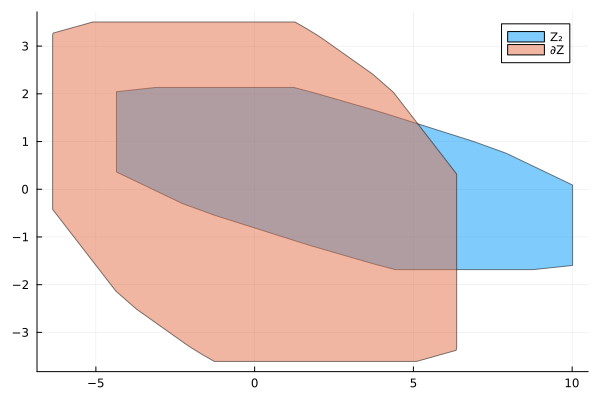

In [120]:
plot(∂Zout.Z₁, label="Z₁", framestyle=:origin, alpha=0.5, title="Output")
plot(∂Zout.Z₂, label="Z₂", alpha=0.5)
plot!(∂Zout.∂Z, label="∂Z", alpha=0.5)

In [121]:
# Initialize the LP solver
model = Model(() -> Gurobi.Optimizer(VeryDiff.GRB_ENV[]))
set_time_limit_sec(model, 10)

# Add variables and input and output constraints
var_num = size(∂Zout.∂Z.G, 2)
@variable(model, -1.0 <= x[1:var_num] <= 1.0)
@constraint(model, ∂Zout.∂Z.G * x + ∂Zout.∂Z.c .>= ϵ + eps(ϵ))

# Add split constraints
for split_node in next_splits
    (;g, c) = prop_state.split_generators[to_dict_key(split_node)]
    @constraint(model, split_node.direction * (g' * x[1:size(g, 1)] + c) >= 0.0)
end
@objective(model, Min, 0)
optimize!(model)

println(termination_status(model))
println(is_solved_and_feasible(model))

if is_solved_and_feasible(model)
    cex = value.(x)[1:size(∂Zin.Z₁.G, 2)]
    sample_distance = VeryDiff.get_sample_distance(N₁, N₂, cex)
    if sample_distance > ϵ
        return false, cex
    end
end

if termination_status(model) != MOI.INFEASIBLE
    println("Neuron splitting counter: $neuron_splits")
    split₁, split₂ = split_neuron(split_candidate.node, (∂Zin, next_splits))
    push!(splits, split₁, split₂)

    neuron_splits += 1
end

OPTIMAL
true
Neuron splitting counter: 0


1

In [122]:
∂Zin, next_splits = popfirst!(splits)
split_candidate = SplitCandidate(SplitNode(1, 1, 1, 0), Inf64)
∂Zout = N(∂Zin, prop_state; split_nodes=next_splits, split_candidate=split_candidate)
prop_satisfied, cex, _, _, _ = property_check(N₁, N₂, ∂Zin, ∂Zout, nothing)

(false, nothing, ([-158.73889438812122 158.73889438812122; -87.01663090395652 86.91369014162768], 0.001, nothing), nothing, 158.73889438812122)

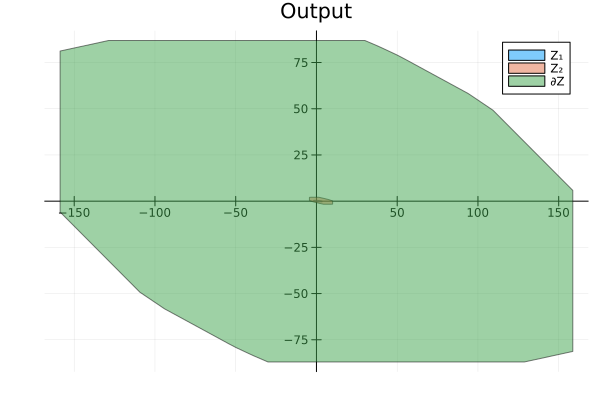

In [123]:
plot(∂Zout.Z₁, label="Z₁", framestyle=:origin, alpha=0.5, title="Output")
plot!(∂Zout.Z₂, label="Z₂", alpha=0.5)
plot!(∂Zout.∂Z, label="∂Z", alpha=0.5)

In [124]:
# Initialize the LP solver
model = Model(() -> Gurobi.Optimizer(VeryDiff.GRB_ENV[]))
set_time_limit_sec(model, 10)

# Add variables and input and output constraints
var_num = size(∂Zout.∂Z.G, 2)
@variable(model, -1.0 <= x[1:var_num] <= 1.0)
@constraint(model, ∂Zout.∂Z.G * x + ∂Zout.∂Z.c .>= ϵ + eps(ϵ))

# Add split constraints
for split_node in next_splits
    (;g, c) = prop_state.split_generators[to_dict_key(split_node)]
    @constraint(model, split_node.direction * (g' * x[1:size(g, 1)] + c) >= 0.0)
end
@objective(model, Min, 0)
optimize!(model)

println(termination_status(model))
println(is_solved_and_feasible(model))

if is_solved_and_feasible(model)
    cex = value.(x)[1:size(∂Zin.Z₁.G, 2)]
    sample_distance = VeryDiff.get_sample_distance(N₁, N₂, cex)
    if sample_distance > ϵ
        return false, cex
    end
end

if termination_status(model) != MOI.INFEASIBLE
    println("Neuron splitting counter: $neuron_splits")
    split₁, split₂ = split_neuron(split_candidate.node, (∂Zin, next_splits))
    push!(splits, split₁, split₂)

    neuron_splits += 1
end

OPTIMAL
true
Neuron splitting counter: 1


2

In [125]:
∂Zin, next_splits = popfirst!(splits)
split_candidate = SplitCandidate(SplitNode(1, 1, 1, 0), Inf64)
∂Zout = N(∂Zin, prop_state; split_nodes=next_splits, split_candidate=split_candidate)
prop_satisfied, cex, _, _, _ = property_check(N₁, N₂, ∂Zin, ∂Zout, nothing)

(false, nothing, ([-6.362523833694274 6.362523833694274; -3.608800409708649 3.5056170790786902], 0.001, nothing), nothing, 6.362523833694274)

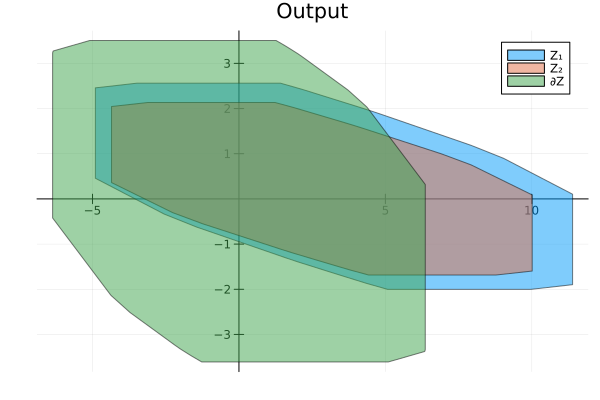

In [126]:
plot(∂Zout.Z₁, label="Z₁", framestyle=:origin, alpha=0.5, title="Output")
plot!(∂Zout.Z₂, label="Z₂", alpha=0.5)
plot!(∂Zout.∂Z, label="∂Z", alpha=0.5)

In [127]:
# Initialize the LP solver
model = Model(() -> Gurobi.Optimizer(VeryDiff.GRB_ENV[]))
set_time_limit_sec(model, 10)

# Add variables and input and output constraints
var_num = size(∂Zout.∂Z.G, 2)
@variable(model, -1.0 <= x[1:var_num] <= 1.0)
@constraint(model, ∂Zout.∂Z.G * x + ∂Zout.∂Z.c .>= ϵ + eps(ϵ))

# Add split constraints
for split_node in next_splits
    (;g, c) = prop_state.split_generators[to_dict_key(split_node)]
    @constraint(model, split_node.direction * (g' * x[1:size(g, 1)] + c) >= 0.0)
end
@objective(model, Min, 0)
optimize!(model)

println(termination_status(model))
println(is_solved_and_feasible(model))

if is_solved_and_feasible(model)
    cex = value.(x)[1:size(∂Zin.Z₁.G, 2)]
    sample_distance = VeryDiff.get_sample_distance(N₁, N₂, cex)
    if sample_distance > ϵ
        return false, cex
    end
end

if termination_status(model) != MOI.INFEASIBLE
    println("Neuron splitting counter: $neuron_splits")
    split₁, split₂ = split_neuron(split_candidate.node, (∂Zin, next_splits))
    push!(splits, split₁, split₂)

    neuron_splits += 1
end

OPTIMAL
true
Neuron splitting counter: 2


3

In [128]:
∂Zin, next_splits = popfirst!(splits)
split_candidate = SplitCandidate(SplitNode(1, 1, 1, 0), Inf64)
∂Zout = N(∂Zin, prop_state; split_nodes=next_splits, split_candidate=split_candidate)
prop_satisfied, cex, _, _, _ = property_check(N₁, N₂, ∂Zin, ∂Zout, nothing)

(false, nothing, ([-158.73889438812122 158.73889438812122; -87.01663090395652 86.91369014162768], 0.001, nothing), nothing, 158.73889438812122)

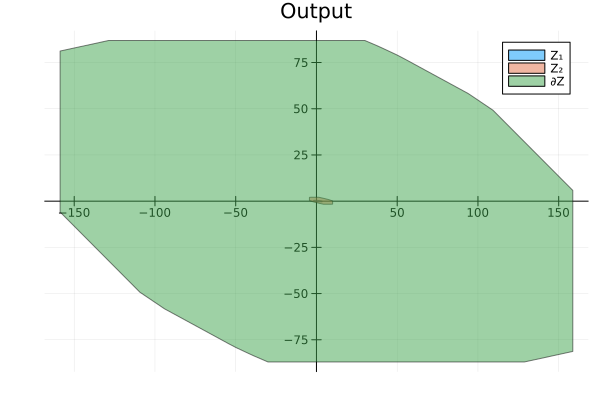

In [129]:
plot(∂Zout.Z₁, label="Z₁", framestyle=:origin, alpha=0.5, title="Output")
plot!(∂Zout.Z₂, label="Z₂", alpha=0.5)
plot!(∂Zout.∂Z, label="∂Z", alpha=0.5)

In [130]:
# Initialize the LP solver
model = Model(() -> Gurobi.Optimizer(VeryDiff.GRB_ENV[]))
set_time_limit_sec(model, 10)

# Add variables and input and output constraints
var_num = size(∂Zout.∂Z.G, 2)
@variable(model, -1.0 <= x[1:var_num] <= 1.0)
@constraint(model, ∂Zout.∂Z.G * x + ∂Zout.∂Z.c .>= ϵ + eps(ϵ))

# Add split constraints
for split_node in next_splits
    (;g, c) = prop_state.split_generators[to_dict_key(split_node)]
    @constraint(model, split_node.direction * (g' * x[1:size(g, 1)] + c) >= 0.0)
end
@objective(model, Min, 0)
optimize!(model)

println(termination_status(model))
println(is_solved_and_feasible(model))

if is_solved_and_feasible(model)
    cex = value.(x)[1:size(∂Zin.Z₁.G, 2)]
    sample_distance = VeryDiff.get_sample_distance(N₁, N₂, cex)
    if sample_distance > ϵ
        return false, cex
    end
end

if termination_status(model) != MOI.INFEASIBLE
    println("Neuron splitting counter: $neuron_splits")
    split₁, split₂ = split_neuron(split_candidate.node, (∂Zin, next_splits))
    push!(splits, split₁, split₂)

    neuron_splits += 1
end

OPTIMAL
true
Neuron splitting counter: 3


4

In [131]:
∂Zin, next_splits = popfirst!(splits)
split_candidate = SplitCandidate(SplitNode(1, 1, 1, 0), Inf64)
∂Zout = N(∂Zin, prop_state; split_nodes=next_splits, split_candidate=split_candidate)
prop_satisfied, cex, _, _, _ = property_check(N₁, N₂, ∂Zin, ∂Zout, nothing)

(false, nothing, ([-6.362523833694274 6.362523833694274; -3.608800409708649 3.5056170790786902], 0.001, nothing), nothing, 6.362523833694274)

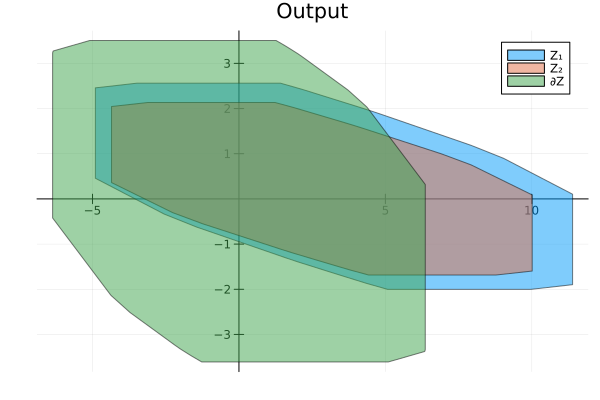

In [132]:
plot(∂Zout.Z₁, label="Z₁", framestyle=:origin, alpha=0.5, title="Output")
plot!(∂Zout.Z₂, label="Z₂", alpha=0.5)
plot!(∂Zout.∂Z, label="∂Z", alpha=0.5)

In [133]:
# Initialize the LP solver
model = Model(() -> Gurobi.Optimizer(VeryDiff.GRB_ENV[]))
set_time_limit_sec(model, 10)

# Add variables and input and output constraints
var_num = size(∂Zout.∂Z.G, 2)
@variable(model, -1.0 <= x[1:var_num] <= 1.0)
@constraint(model, ∂Zout.∂Z.G * x + ∂Zout.∂Z.c .>= ϵ + eps(ϵ))

# Add split constraints
for split_node in next_splits
    (;g, c) = prop_state.split_generators[to_dict_key(split_node)]
    @constraint(model, split_node.direction * (g' * x[1:size(g, 1)] + c) >= 0.0)
end
@objective(model, Min, 0)
optimize!(model)

println(termination_status(model))
println(is_solved_and_feasible(model))

if is_solved_and_feasible(model)
    cex = value.(x)[1:size(∂Zin.Z₁.G, 2)]
    sample_distance = VeryDiff.get_sample_distance(N₁, N₂, cex)
    if sample_distance > ϵ
        return false, cex
    end
end

if termination_status(model) != MOI.INFEASIBLE
    println("Neuron splitting counter: $neuron_splits")
    split₁, split₂ = split_neuron(split_candidate.node, (∂Zin, next_splits))
    push!(splits, split₁, split₂)

    neuron_splits += 1
end

OPTIMAL
true
Neuron splitting counter: 4


5

In [134]:
∂Zin, next_splits = popfirst!(splits)
split_candidate = SplitCandidate(SplitNode(1, 1, 1, 0), Inf64)
∂Zout = N(∂Zin, prop_state; split_nodes=next_splits, split_candidate=split_candidate)
prop_satisfied, cex, _, _, _ = property_check(N₁, N₂, ∂Zin, ∂Zout, nothing)

(false, nothing, ([-158.73889438812122 158.73889438812122; -87.01663090395652 86.91369014162768], 0.001, nothing), nothing, 158.73889438812122)

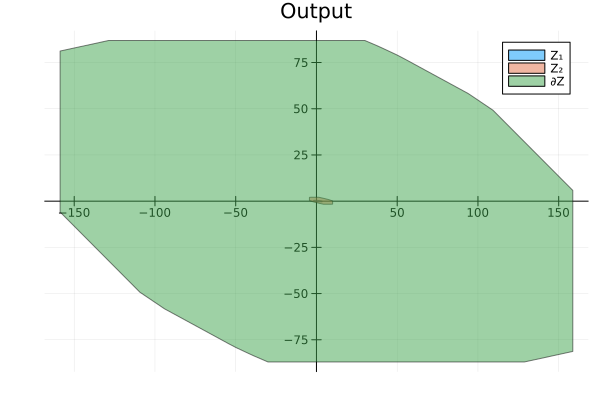

In [135]:
plot(∂Zout.Z₁, label="Z₁", framestyle=:origin, alpha=0.5, title="Output")
plot!(∂Zout.Z₂, label="Z₂", alpha=0.5)
plot!(∂Zout.∂Z, label="∂Z", alpha=0.5)

In [136]:
# Initialize the LP solver
model = Model(() -> Gurobi.Optimizer(VeryDiff.GRB_ENV[]))
set_time_limit_sec(model, 10)

# Add variables and input and output constraints
var_num = size(∂Zout.∂Z.G, 2)
@variable(model, -1.0 <= x[1:var_num] <= 1.0)
@constraint(model, ∂Zout.∂Z.G * x + ∂Zout.∂Z.c .>= ϵ + eps(ϵ))

# Add split constraints
for split_node in next_splits
    (;g, c) = prop_state.split_generators[to_dict_key(split_node)]
    @constraint(model, split_node.direction * (g' * x[1:size(g, 1)] + c) >= 0.0)
end
@objective(model, Min, 0)
optimize!(model)

println(termination_status(model))
println(is_solved_and_feasible(model))

if is_solved_and_feasible(model)
    cex = value.(x)[1:size(∂Zin.Z₁.G, 2)]
    sample_distance = VeryDiff.get_sample_distance(N₁, N₂, cex)
    if sample_distance > ϵ
        return false, cex
    end
end

if termination_status(model) != MOI.INFEASIBLE
    println("Neuron splitting counter: $neuron_splits")
    split₁, split₂ = split_neuron(split_candidate.node, (∂Zin, next_splits))
    push!(splits, split₁, split₂)

    neuron_splits += 1
end

OPTIMAL
true
Neuron splitting counter: 5


6

In [137]:
∂Zin, next_splits = popfirst!(splits)
split_candidate = SplitCandidate(SplitNode(1, 1, 1, 0), Inf64)
∂Zout = N(∂Zin, prop_state; split_nodes=next_splits, split_candidate=split_candidate)
prop_satisfied, cex, _, _, _ = property_check(N₁, N₂, ∂Zin, ∂Zout, nothing)

(false, nothing, ([-6.362523833694274 6.362523833694274; -3.608800409708649 3.5056170790786902], 0.001, nothing), nothing, 6.362523833694274)

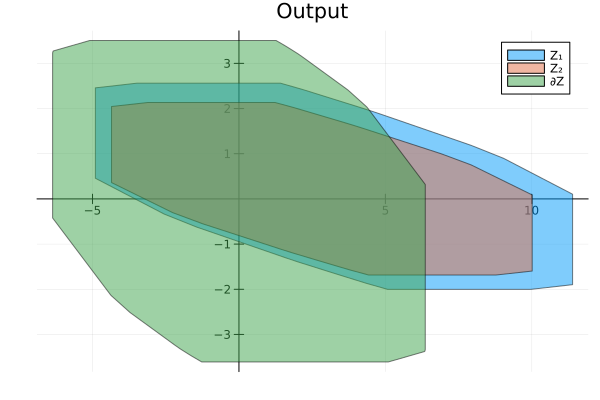

In [138]:
plot(∂Zout.Z₁, label="Z₁", framestyle=:origin, alpha=0.5, title="Output")
plot!(∂Zout.Z₂, label="Z₂", alpha=0.5)
plot!(∂Zout.∂Z, label="∂Z", alpha=0.5)

In [139]:
# Initialize the LP solver
model = Model(() -> Gurobi.Optimizer(VeryDiff.GRB_ENV[]))
set_time_limit_sec(model, 10)

# Add variables and input and output constraints
var_num = size(∂Zout.∂Z.G, 2)
@variable(model, -1.0 <= x[1:var_num] <= 1.0)
@constraint(model, ∂Zout.∂Z.G * x + ∂Zout.∂Z.c .>= ϵ + eps(ϵ))

# Add split constraints
for split_node in next_splits
    (;g, c) = prop_state.split_generators[to_dict_key(split_node)]
    @constraint(model, split_node.direction * (g' * x[1:size(g, 1)] + c) >= 0.0)
end
@objective(model, Min, 0)
optimize!(model)

println(termination_status(model))
println(is_solved_and_feasible(model))

if is_solved_and_feasible(model)
    cex = value.(x)[1:size(∂Zin.Z₁.G, 2)]
    sample_distance = VeryDiff.get_sample_distance(N₁, N₂, cex)
    if sample_distance > ϵ
        return false, cex
    end
end

if termination_status(model) != MOI.INFEASIBLE
    println("Neuron splitting counter: $neuron_splits")
    split₁, split₂ = split_neuron(split_candidate.node, (∂Zin, next_splits))
    push!(splits, split₁, split₂)

    neuron_splits += 1
end

OPTIMAL
true
Neuron splitting counter: 6


7

In [140]:
∂Zin, next_splits = popfirst!(splits)
split_candidate = SplitCandidate(SplitNode(1, 1, 1, 0), Inf64)
∂Zout = N(∂Zin, prop_state; split_nodes=next_splits, split_candidate=split_candidate)
prop_satisfied, cex, _, _, _ = property_check(N₁, N₂, ∂Zin, ∂Zout, nothing)

(false, nothing, ([-158.73889438812122 158.73889438812122; -87.01663090395652 86.91369014162768], 0.001, nothing), nothing, 158.73889438812122)

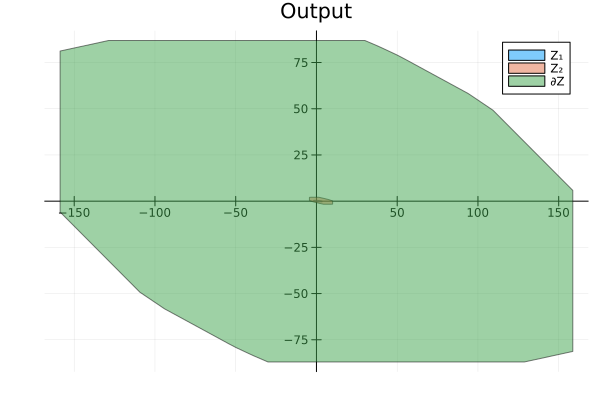

In [141]:
plot(∂Zout.Z₁, label="Z₁", framestyle=:origin, alpha=0.5, title="Output")
plot!(∂Zout.Z₂, label="Z₂", alpha=0.5)
plot!(∂Zout.∂Z, label="∂Z", alpha=0.5)

In [142]:
# Initialize the LP solver
model = Model(() -> Gurobi.Optimizer(VeryDiff.GRB_ENV[]))
set_time_limit_sec(model, 10)

# Add variables and input and output constraints
var_num = size(∂Zout.∂Z.G, 2)
@variable(model, -1.0 <= x[1:var_num] <= 1.0)
@constraint(model, ∂Zout.∂Z.G * x + ∂Zout.∂Z.c .>= ϵ + eps(ϵ))

# Add split constraints
for split_node in next_splits
    (;g, c) = prop_state.split_generators[to_dict_key(split_node)]
    @constraint(model, split_node.direction * (g' * x[1:size(g, 1)] + c) >= 0.0)
end
@objective(model, Min, 0)
optimize!(model)

println(termination_status(model))
println(is_solved_and_feasible(model))

if is_solved_and_feasible(model)
    cex = value.(x)[1:size(∂Zin.Z₁.G, 2)]
    sample_distance = VeryDiff.get_sample_distance(N₁, N₂, cex)
    if sample_distance > ϵ
        return false, cex
    end
end

if termination_status(model) != MOI.INFEASIBLE
    println("Neuron splitting counter: $neuron_splits")
    split₁, split₂ = split_neuron(split_candidate.node, (∂Zin, next_splits))
    push!(splits, split₁, split₂)

    neuron_splits += 1
end

OPTIMAL
true
Neuron splitting counter: 7


8

In [143]:
∂Zin, next_splits = popfirst!(splits)
split_candidate = SplitCandidate(SplitNode(1, 1, 1, 0), Inf64)
∂Zout = N(∂Zin, prop_state; split_nodes=next_splits, split_candidate=split_candidate)
prop_satisfied, cex, _, _, _ = property_check(N₁, N₂, ∂Zin, ∂Zout, nothing)

(false, nothing, ([-6.362523833694274 6.362523833694274; -3.608800409708649 3.5056170790786902], 0.001, nothing), nothing, 6.362523833694274)

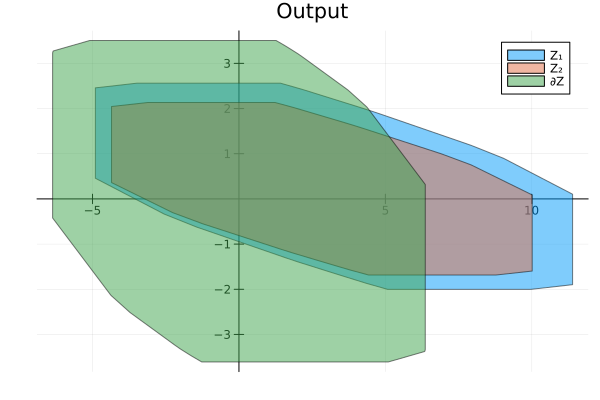

In [144]:
plot(∂Zout.Z₁, label="Z₁", framestyle=:origin, alpha=0.5, title="Output")
plot!(∂Zout.Z₂, label="Z₂", alpha=0.5)
plot!(∂Zout.∂Z, label="∂Z", alpha=0.5)

In [145]:
# Initialize the LP solver
model = Model(() -> Gurobi.Optimizer(VeryDiff.GRB_ENV[]))
set_time_limit_sec(model, 10)

# Add variables and input and output constraints
var_num = size(∂Zout.∂Z.G, 2)
@variable(model, -1.0 <= x[1:var_num] <= 1.0)
@constraint(model, ∂Zout.∂Z.G * x + ∂Zout.∂Z.c .>= ϵ + eps(ϵ))

# Add split constraints
for split_node in next_splits
    (;g, c) = prop_state.split_generators[to_dict_key(split_node)]
    @constraint(model, split_node.direction * (g' * x[1:size(g, 1)] + c) >= 0.0)
end
@objective(model, Min, 0)
optimize!(model)

println(termination_status(model))
println(is_solved_and_feasible(model))

if is_solved_and_feasible(model)
    cex = value.(x)[1:size(∂Zin.Z₁.G, 2)]
    sample_distance = VeryDiff.get_sample_distance(N₁, N₂, cex)
    if sample_distance > ϵ
        return false, cex
    end
end

if termination_status(model) != MOI.INFEASIBLE
    println("Neuron splitting counter: $neuron_splits")
    split₁, split₂ = split_neuron(split_candidate.node, (∂Zin, next_splits))
    push!(splits, split₁, split₂)

    neuron_splits += 1
end

OPTIMAL
true
Neuron splitting counter: 8


9

In [146]:
∂Zin, next_splits = popfirst!(splits)
split_candidate = SplitCandidate(SplitNode(1, 1, 1, 0), Inf64)
∂Zout = N(∂Zin, prop_state; split_nodes=next_splits, split_candidate=split_candidate)
prop_satisfied, cex, _, _, _ = property_check(N₁, N₂, ∂Zin, ∂Zout, nothing)

(false, nothing, ([-158.73889438812122 158.73889438812122; -87.01663090395652 86.91369014162768], 0.001, nothing), nothing, 158.73889438812122)

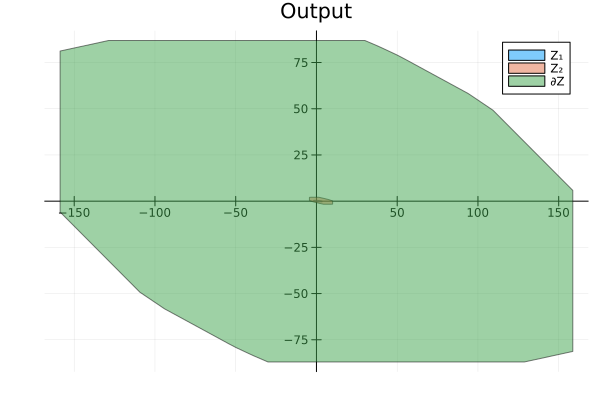

In [147]:
plot(∂Zout.Z₁, label="Z₁", framestyle=:origin, alpha=0.5, title="Output")
plot!(∂Zout.Z₂, label="Z₂", alpha=0.5)
plot!(∂Zout.∂Z, label="∂Z", alpha=0.5)

In [148]:
# Initialize the LP solver
model = Model(() -> Gurobi.Optimizer(VeryDiff.GRB_ENV[]))
set_time_limit_sec(model, 10)

# Add variables and input and output constraints
var_num = size(∂Zout.∂Z.G, 2)
@variable(model, -1.0 <= x[1:var_num] <= 1.0)
@constraint(model, ∂Zout.∂Z.G * x + ∂Zout.∂Z.c .>= ϵ + eps(ϵ))

# Add split constraints
for split_node in next_splits
    (;g, c) = prop_state.split_generators[to_dict_key(split_node)]
    @constraint(model, split_node.direction * (g' * x[1:size(g, 1)] + c) >= 0.0)
end
@objective(model, Min, 0)
optimize!(model)

println(termination_status(model))
println(is_solved_and_feasible(model))

if is_solved_and_feasible(model)
    cex = value.(x)[1:size(∂Zin.Z₁.G, 2)]
    sample_distance = VeryDiff.get_sample_distance(N₁, N₂, cex)
    if sample_distance > ϵ
        return false, cex
    end
end

if termination_status(model) != MOI.INFEASIBLE
    println("Neuron splitting counter: $neuron_splits")
    split₁, split₂ = split_neuron(split_candidate.node, (∂Zin, next_splits))
    push!(splits, split₁, split₂)

    neuron_splits += 1
end

OPTIMAL
true
Neuron splitting counter: 9


10

In [149]:
∂Zin, next_splits = popfirst!(splits)
split_candidate = SplitCandidate(SplitNode(1, 1, 1, 0), Inf64)
∂Zout = N(∂Zin, prop_state; split_nodes=next_splits, split_candidate=split_candidate)
prop_satisfied, cex, _, _, _ = property_check(N₁, N₂, ∂Zin, ∂Zout, nothing)

(false, nothing, ([-6.362523833694274 6.362523833694274; -3.608800409708649 3.5056170790786902], 0.001, nothing), nothing, 6.362523833694274)

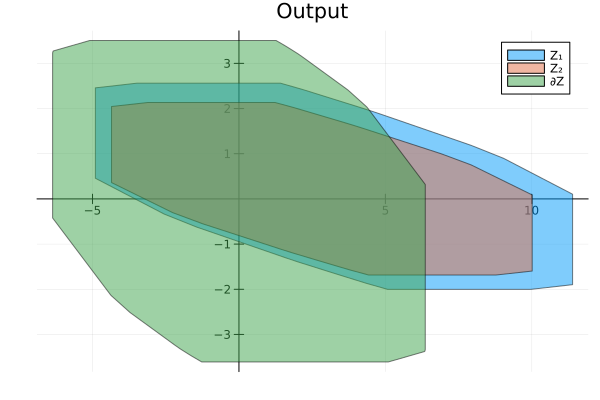

In [150]:
plot(∂Zout.Z₁, label="Z₁", framestyle=:origin, alpha=0.5, title="Output")
plot!(∂Zout.Z₂, label="Z₂", alpha=0.5)
plot!(∂Zout.∂Z, label="∂Z", alpha=0.5)

In [151]:
# Initialize the LP solver
model = Model(() -> Gurobi.Optimizer(VeryDiff.GRB_ENV[]))
set_time_limit_sec(model, 10)

# Add variables and input and output constraints
var_num = size(∂Zout.∂Z.G, 2)
@variable(model, -1.0 <= x[1:var_num] <= 1.0)
@constraint(model, ∂Zout.∂Z.G * x + ∂Zout.∂Z.c .>= ϵ + eps(ϵ))

# Add split constraints
for split_node in next_splits
    (;g, c) = prop_state.split_generators[to_dict_key(split_node)]
    @constraint(model, split_node.direction * (g' * x[1:size(g, 1)] + c) >= 0.0)
end
@objective(model, Min, 0)
optimize!(model)

println(termination_status(model))
println(is_solved_and_feasible(model))

if is_solved_and_feasible(model)
    cex = value.(x)[1:size(∂Zin.Z₁.G, 2)]
    sample_distance = VeryDiff.get_sample_distance(N₁, N₂, cex)
    if sample_distance > ϵ
        return false, cex
    end
end

if termination_status(model) != MOI.INFEASIBLE
    println("Neuron splitting counter: $neuron_splits")
    split₁, split₂ = split_neuron(split_candidate.node, (∂Zin, next_splits))
    push!(splits, split₁, split₂)

    neuron_splits += 1
end

OPTIMAL
true
Neuron splitting counter: 10


11

In [152]:
∂Zin, next_splits = popfirst!(splits)
split_candidate = SplitCandidate(SplitNode(1, 1, 1, 0), Inf64)
∂Zout = N(∂Zin, prop_state; split_nodes=next_splits, split_candidate=split_candidate)
prop_satisfied, cex, _, _, _ = property_check(N₁, N₂, ∂Zin, ∂Zout, nothing)

(false, nothing, ([-158.73889438812122 158.73889438812122; -87.01663090395652 86.91369014162768], 0.001, nothing), nothing, 158.73889438812122)

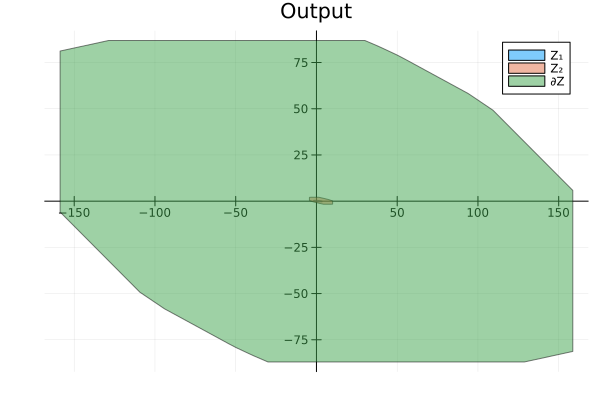

In [153]:
plot(∂Zout.Z₁, label="Z₁", framestyle=:origin, alpha=0.5, title="Output")
plot!(∂Zout.Z₂, label="Z₂", alpha=0.5)
plot!(∂Zout.∂Z, label="∂Z", alpha=0.5)

In [154]:
# Initialize the LP solver
model = Model(() -> Gurobi.Optimizer(VeryDiff.GRB_ENV[]))
set_time_limit_sec(model, 10)

# Add variables and input and output constraints
var_num = size(∂Zout.∂Z.G, 2)
@variable(model, -1.0 <= x[1:var_num] <= 1.0)
@constraint(model, ∂Zout.∂Z.G * x + ∂Zout.∂Z.c .>= ϵ + eps(ϵ))

# Add split constraints
for split_node in next_splits
    (;g, c) = prop_state.split_generators[to_dict_key(split_node)]
    @constraint(model, split_node.direction * (g' * x[1:size(g, 1)] + c) >= 0.0)
end
@objective(model, Min, 0)
optimize!(model)

println(termination_status(model))
println(is_solved_and_feasible(model))

if is_solved_and_feasible(model)
    cex = value.(x)[1:size(∂Zin.Z₁.G, 2)]
    sample_distance = VeryDiff.get_sample_distance(N₁, N₂, cex)
    if sample_distance > ϵ
        return false, cex
    end
end

if termination_status(model) != MOI.INFEASIBLE
    println("Neuron splitting counter: $neuron_splits")
    split₁, split₂ = split_neuron(split_candidate.node, (∂Zin, next_splits))
    push!(splits, split₁, split₂)

    neuron_splits += 1
end

OPTIMAL
true
Neuron splitting counter: 11


12

In [155]:
∂Zin, next_splits = popfirst!(splits)
split_candidate = SplitCandidate(SplitNode(1, 1, 1, 0), Inf64)
∂Zout = N(∂Zin, prop_state; split_nodes=next_splits, split_candidate=split_candidate)
prop_satisfied, cex, _, _, _ = property_check(N₁, N₂, ∂Zin, ∂Zout, nothing)

(false, nothing, ([-6.362523833694274 6.362523833694274; -3.608800409708649 3.5056170790786902], 0.001, nothing), nothing, 6.362523833694274)

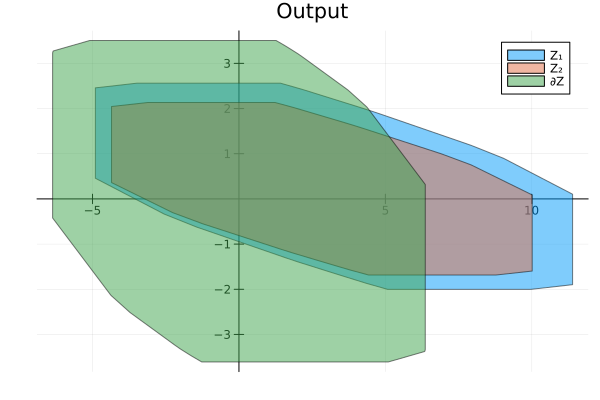

In [156]:
plot(∂Zout.Z₁, label="Z₁", framestyle=:origin, alpha=0.5, title="Output")
plot!(∂Zout.Z₂, label="Z₂", alpha=0.5)
plot!(∂Zout.∂Z, label="∂Z", alpha=0.5)

In [157]:
# Initialize the LP solver
model = Model(() -> Gurobi.Optimizer(VeryDiff.GRB_ENV[]))
set_time_limit_sec(model, 10)

# Add variables and input and output constraints
var_num = size(∂Zout.∂Z.G, 2)
@variable(model, -1.0 <= x[1:var_num] <= 1.0)
@constraint(model, ∂Zout.∂Z.G * x + ∂Zout.∂Z.c .>= ϵ + eps(ϵ))

# Add split constraints
for split_node in next_splits
    (;g, c) = prop_state.split_generators[to_dict_key(split_node)]
    @constraint(model, split_node.direction * (g' * x[1:size(g, 1)] + c) >= 0.0)
end
@objective(model, Min, 0)
optimize!(model)

println(termination_status(model))
println(is_solved_and_feasible(model))

if is_solved_and_feasible(model)
    cex = value.(x)[1:size(∂Zin.Z₁.G, 2)]
    sample_distance = VeryDiff.get_sample_distance(N₁, N₂, cex)
    if sample_distance > ϵ
        return false, cex
    end
end

if termination_status(model) != MOI.INFEASIBLE
    println("Neuron splitting counter: $neuron_splits")
    split₁, split₂ = split_neuron(split_candidate.node, (∂Zin, next_splits))
    push!(splits, split₁, split₂)

    neuron_splits += 1
end

OPTIMAL
true
Neuron splitting counter: 12


13

In [158]:
∂Zin, next_splits = popfirst!(splits)
split_candidate = SplitCandidate(SplitNode(1, 1, 1, 0), Inf64)
∂Zout = N(∂Zin, prop_state; split_nodes=next_splits, split_candidate=split_candidate)
prop_satisfied, cex, _, _, _ = property_check(N₁, N₂, ∂Zin, ∂Zout, nothing)

(false, nothing, ([-158.73889438812122 158.73889438812122; -87.01663090395652 86.91369014162768], 0.001, nothing), nothing, 158.73889438812122)

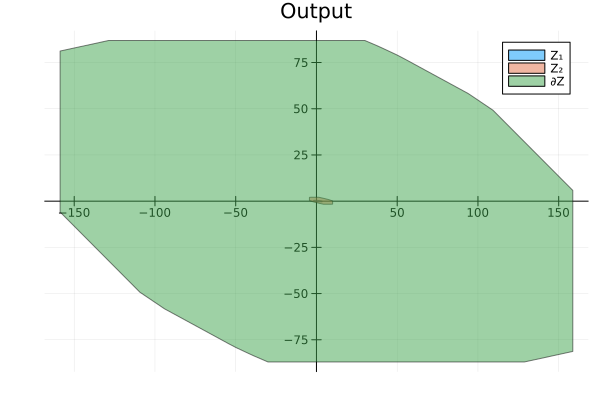

In [159]:
plot(∂Zout.Z₁, label="Z₁", framestyle=:origin, alpha=0.5, title="Output")
plot!(∂Zout.Z₂, label="Z₂", alpha=0.5)
plot!(∂Zout.∂Z, label="∂Z", alpha=0.5)

In [160]:
# Initialize the LP solver
model = Model(() -> Gurobi.Optimizer(VeryDiff.GRB_ENV[]))
set_time_limit_sec(model, 10)

# Add variables and input and output constraints
var_num = size(∂Zout.∂Z.G, 2)
@variable(model, -1.0 <= x[1:var_num] <= 1.0)
@constraint(model, ∂Zout.∂Z.G * x + ∂Zout.∂Z.c .>= ϵ + eps(ϵ))

# Add split constraints
for split_node in next_splits
    (;g, c) = prop_state.split_generators[to_dict_key(split_node)]
    @constraint(model, split_node.direction * (g' * x[1:size(g, 1)] + c) >= 0.0)
end
@objective(model, Min, 0)
optimize!(model)

println(termination_status(model))
println(is_solved_and_feasible(model))

if is_solved_and_feasible(model)
    cex = value.(x)[1:size(∂Zin.Z₁.G, 2)]
    sample_distance = VeryDiff.get_sample_distance(N₁, N₂, cex)
    if sample_distance > ϵ
        return false, cex
    end
end

if termination_status(model) != MOI.INFEASIBLE
    println("Neuron splitting counter: $neuron_splits")
    split₁, split₂ = split_neuron(split_candidate.node, (∂Zin, next_splits))
    push!(splits, split₁, split₂)

    neuron_splits += 1
end

OPTIMAL
true
Neuron splitting counter: 13


14

In [161]:
∂Zin, next_splits = popfirst!(splits)
split_candidate = SplitCandidate(SplitNode(1, 1, 1, 0), Inf64)
∂Zout = N(∂Zin, prop_state; split_nodes=next_splits, split_candidate=split_candidate)
prop_satisfied, cex, _, _, _ = property_check(N₁, N₂, ∂Zin, ∂Zout, nothing)

(false, nothing, ([-6.362523833694274 6.362523833694274; -3.608800409708649 3.5056170790786902], 0.001, nothing), nothing, 6.362523833694274)

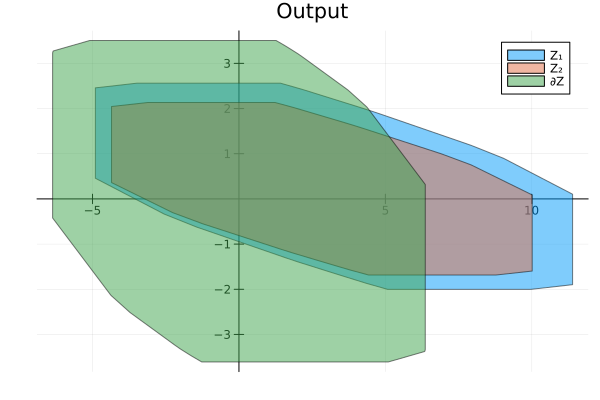

In [162]:
plot(∂Zout.Z₁, label="Z₁", framestyle=:origin, alpha=0.5, title="Output")
plot!(∂Zout.Z₂, label="Z₂", alpha=0.5)
plot!(∂Zout.∂Z, label="∂Z", alpha=0.5)

In [163]:
# Initialize the LP solver
model = Model(() -> Gurobi.Optimizer(VeryDiff.GRB_ENV[]))
set_time_limit_sec(model, 10)

# Add variables and input and output constraints
var_num = size(∂Zout.∂Z.G, 2)
@variable(model, -1.0 <= x[1:var_num] <= 1.0)
@constraint(model, ∂Zout.∂Z.G * x + ∂Zout.∂Z.c .>= ϵ + eps(ϵ))

# Add split constraints
for split_node in next_splits
    (;g, c) = prop_state.split_generators[to_dict_key(split_node)]
    @constraint(model, split_node.direction * (g' * x[1:size(g, 1)] + c) >= 0.0)
end
@objective(model, Min, 0)
optimize!(model)

println(termination_status(model))
println(is_solved_and_feasible(model))

if is_solved_and_feasible(model)
    cex = value.(x)[1:size(∂Zin.Z₁.G, 2)]
    sample_distance = VeryDiff.get_sample_distance(N₁, N₂, cex)
    if sample_distance > ϵ
        return false, cex
    end
end

if termination_status(model) != MOI.INFEASIBLE
    println("Neuron splitting counter: $neuron_splits")
    split₁, split₂ = split_neuron(split_candidate.node, (∂Zin, next_splits))
    push!(splits, split₁, split₂)

    neuron_splits += 1
end

OPTIMAL
true
Neuron splitting counter: 14


15

In [164]:
∂Zin, next_splits = popfirst!(splits)
split_candidate = SplitCandidate(SplitNode(1, 1, 1, 0), Inf64)
∂Zout = N(∂Zin, prop_state; split_nodes=next_splits, split_candidate=split_candidate)
prop_satisfied, cex, _, _, _ = property_check(N₁, N₂, ∂Zin, ∂Zout, nothing)

(false, nothing, ([-158.73889438812122 158.73889438812122; -87.01663090395652 86.91369014162768], 0.001, nothing), nothing, 158.73889438812122)

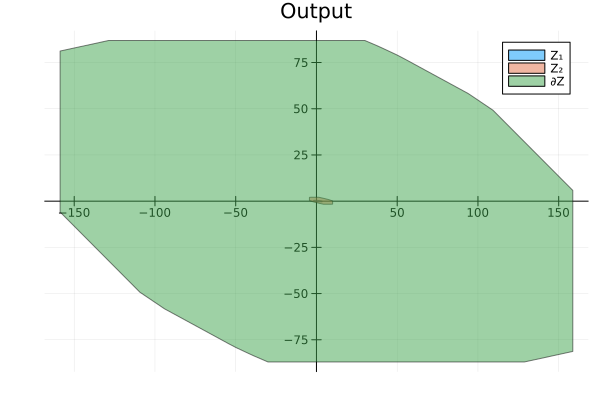

In [165]:
plot(∂Zout.Z₁, label="Z₁", framestyle=:origin, alpha=0.5, title="Output")
plot!(∂Zout.Z₂, label="Z₂", alpha=0.5)
plot!(∂Zout.∂Z, label="∂Z", alpha=0.5)

In [166]:
# Initialize the LP solver
model = Model(() -> Gurobi.Optimizer(VeryDiff.GRB_ENV[]))
set_time_limit_sec(model, 10)

# Add variables and input and output constraints
var_num = size(∂Zout.∂Z.G, 2)
@variable(model, -1.0 <= x[1:var_num] <= 1.0)
@constraint(model, ∂Zout.∂Z.G * x + ∂Zout.∂Z.c .>= ϵ + eps(ϵ))

# Add split constraints
for split_node in next_splits
    (;g, c) = prop_state.split_generators[to_dict_key(split_node)]
    @constraint(model, split_node.direction * (g' * x[1:size(g, 1)] + c) >= 0.0)
end
@objective(model, Min, 0)
optimize!(model)

println(termination_status(model))
println(is_solved_and_feasible(model))

if is_solved_and_feasible(model)
    cex = value.(x)[1:size(∂Zin.Z₁.G, 2)]
    sample_distance = VeryDiff.get_sample_distance(N₁, N₂, cex)
    if sample_distance > ϵ
        return false, cex
    end
end

if termination_status(model) != MOI.INFEASIBLE
    println("Neuron splitting counter: $neuron_splits")
    split₁, split₂ = split_neuron(split_candidate.node, (∂Zin, next_splits))
    push!(splits, split₁, split₂)

    neuron_splits += 1
end

OPTIMAL
true
Neuron splitting counter: 15


16

In [167]:
∂Zin, next_splits = popfirst!(splits)
split_candidate = SplitCandidate(SplitNode(1, 1, 1, 0), Inf64)
∂Zout = N(∂Zin, prop_state; split_nodes=next_splits, split_candidate=split_candidate)
prop_satisfied, cex, _, _, _ = property_check(N₁, N₂, ∂Zin, ∂Zout, nothing)

(false, nothing, ([-6.362523833694274 6.362523833694274; -3.608800409708649 3.5056170790786902], 0.001, nothing), nothing, 6.362523833694274)

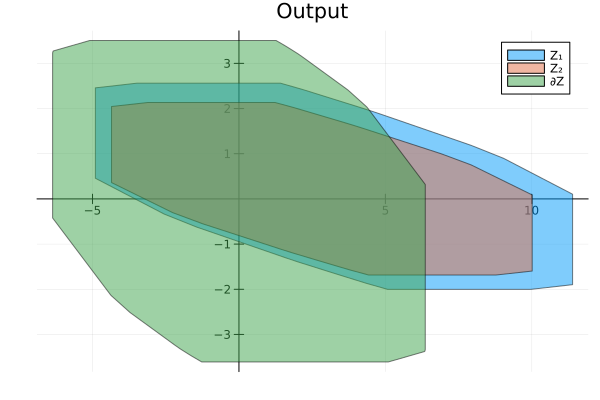

In [168]:
plot(∂Zout.Z₁, label="Z₁", framestyle=:origin, alpha=0.5, title="Output")
plot!(∂Zout.Z₂, label="Z₂", alpha=0.5)
plot!(∂Zout.∂Z, label="∂Z", alpha=0.5)

In [169]:
# Initialize the LP solver
model = Model(() -> Gurobi.Optimizer(VeryDiff.GRB_ENV[]))
set_time_limit_sec(model, 10)

# Add variables and input and output constraints
var_num = size(∂Zout.∂Z.G, 2)
@variable(model, -1.0 <= x[1:var_num] <= 1.0)
@constraint(model, ∂Zout.∂Z.G * x + ∂Zout.∂Z.c .>= ϵ + eps(ϵ))

# Add split constraints
for split_node in next_splits
    (;g, c) = prop_state.split_generators[to_dict_key(split_node)]
    @constraint(model, split_node.direction * (g' * x[1:size(g, 1)] + c) >= 0.0)
end
@objective(model, Min, 0)
optimize!(model)

println(termination_status(model))
println(is_solved_and_feasible(model))

if is_solved_and_feasible(model)
    cex = value.(x)[1:size(∂Zin.Z₁.G, 2)]
    sample_distance = VeryDiff.get_sample_distance(N₁, N₂, cex)
    if sample_distance > ϵ
        return false, cex
    end
end

if termination_status(model) != MOI.INFEASIBLE
    println("Neuron splitting counter: $neuron_splits")
    split₁, split₂ = split_neuron(split_candidate.node, (∂Zin, next_splits))
    push!(splits, split₁, split₂)

    neuron_splits += 1
end

OPTIMAL
true
Neuron splitting counter: 16


17